## Identify the potential factors affecting the mRNA-protein correlation

**Input:** 
<ul>
    <li> All 13 studies' mRNa-protein correlation</li>
    <li> Aggregated protein reproducibility</li>
    <li> Protein properties - abundance, unique peptides, half-lives.</ul>
</ul>          

#### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import math 
import matplotlib as mpl
from matplotlib import pyplot as plt

import common_utils
import graphing_utils as gu
import customized_plots
%matplotlib inline
plt.style.use(['seaborn-white'])

In [2]:
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'+'/'.join(folders) +'/'+ fname)

file_mRNA_protein_correlation = get_local_data_path(['results'], 'TableS1.xlsx')
file_proteomic_replicate_ranks = get_local_data_path(['results'], 'TableS2.xlsx')
file_protein_properties = get_local_data_path(['processed'], 'protein_properties.csv')

#### Load data

In [3]:
proteomic_replicate_rank = pd.read_excel(file_proteomic_replicate_ranks, sheet_name='B. Protein reproducibility rank', 
                                         index_col=0)
proteomic_replicate_rank.rename(columns = lambda x: x.replace(' Reproducibility Rank', ''), inplace=True)
proteomic_replicate_rank[:2]

,Ovarian,Colon,CCLE,Aggregated
A1BG,0.772775,0.45424,NaN,0.575671
A2M,0.883270,0.39603,0.22406,0.501120


In [4]:
aggregated_ranks = proteomic_replicate_rank['Aggregated'].copy(deep=True).dropna()

In [5]:
mRNA_protein_correlation = pd.read_excel(file_mRNA_protein_correlation, 
                                         sheet_name='A. mRNA-protein correlation', index_col=0)
mRNA_protein_correlation[:2]

,CRC (2014),BrCa (2016),Ovarian,Colon,ccRCC,EC,LUAD,BrCa (2020),HNSCC,GBM,NCI60,CCLE,GTEx
Gene symbol,,,,,,,,,,,,,
A1BG,0.123133,-0.093805,-0.078889,NaN,0.035573,0.324974,-0.119663,0.077242,0.065872,-0.192863,NaN,NaN,0.154523
A1CF,NaN,NaN,NaN,0.673548,0.908613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188605


In [6]:
crc14 = mRNA_protein_correlation['CRC (2014)'].copy(deep=True).dropna()
brca16 = mRNA_protein_correlation['BrCa (2016)'].copy(deep=True).dropna()
ovca = mRNA_protein_correlation['Ovarian'].copy(deep=True).dropna()
crc19 = mRNA_protein_correlation['Colon'].copy(deep=True).dropna()
ccrcc = mRNA_protein_correlation['ccRCC'].copy(deep=True).dropna()
ec = mRNA_protein_correlation['EC'].copy(deep=True).dropna()
luad = mRNA_protein_correlation['LUAD'].copy(deep=True).dropna()
brca20 = mRNA_protein_correlation['BrCa (2020)'].copy(deep=True).dropna()
hnscc = mRNA_protein_correlation['HNSCC'].copy(deep=True).dropna()
gbm = mRNA_protein_correlation['GBM'].copy(deep=True).dropna()
ccle = mRNA_protein_correlation['CCLE'].copy(deep=True).dropna()
nci60 = mRNA_protein_correlation['NCI60'].copy(deep=True).dropna()
gtex = mRNA_protein_correlation['GTEx'].copy(deep=True).dropna()

In [7]:
protein_properties = pd.read_csv(file_protein_properties, index_col=0)
protein_properties[:2]

,GTEx_Mean_Abundance,GTEx_Abundance_Variance,GTEx_Unique_Peptides,Protein sequence length,Molecular weight [kDa],T1/2 [h]
A1BG,1357.680477,2.402719e+06,22.0,NaN,NaN,NaN
A2M,10540.179562,1.272133e+08,77.0,NaN,NaN,NaN


In [8]:
protein_abundance = protein_properties['GTEx_Mean_Abundance'].copy(deep=True).dropna()
protein_unique_peptides = protein_properties['GTEx_Unique_Peptides'].copy(deep=True).dropna()
protein_variance = protein_properties['GTEx_Abundance_Variance'].copy(deep=True).dropna()
protein_half_lives = protein_properties['T1/2 [h]'].copy(deep=True).dropna()

In [9]:
print("Protien half-life Range: ", protein_half_lives.min(), " - ", protein_half_lives.max())
print("Protien mean abundance Range: ", protein_abundance.min(), " - ", protein_abundance.max())
print("Protien variance Range: ", protein_variance.min(), " - ", protein_variance.max())
print("Protien unique peptides Range: ", protein_unique_peptides.min(), " - ", protein_unique_peptides.max())
print("Thus, log-transformation is applied to all the above factors!")
protein_half_lives = np.log10(protein_half_lives + 1)
protein_abundance = np.log10(protein_abundance + 1)
protein_variance = np.log10(protein_variance + 1)
protein_unique_peptides = np.log10(protein_unique_peptides + 1)

Protien half-life Range:  0.2331348885205769  -  inf
Protien mean abundance Range:  76.17350896130952  -  387741.52997729526
Protien variance Range:  4075.3577700525416  -  1537082143133.7432
Protien unique peptides Range:  1.0  -  2558.0
Thus, log-transformation is applied to all the above factors!


In [10]:
#converting half-lives to binary - 'Long' and 'Short' 
protein_half_lives_binary = pd.Series(['Long' if val > protein_half_lives.median() \
                                       else 'Short' for val in protein_half_lives], 
                                      index=protein_half_lives.index)

**Performing Mann-Whitney test to ensure the Aggregated Protein Reproduciility Rank are protein half-lives 'Long' and 'short' are from different distribution**

#### Regress to understand the amount of variation in aggregated ranks explained by each of the factor

In [11]:
import statsmodels.api as sm
def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = common_utils.get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset)).fit()
    return est

In [12]:
combined_factors = pd.concat([protein_abundance, protein_variance, pd.get_dummies(protein_half_lives_binary), 
                              protein_unique_peptides, aggregated_ranks.rename('Protein_Reproducibility')], 
                             axis=1, join='inner')
print('Dimensions: ', combined_factors.shape)
combined_factors[:2]

Dimensions:  (3441, 6)


,GTEx_Mean_Abundance,GTEx_Abundance_Variance,Long,Short,GTEx_Unique_Peptides,Protein_Reproducibility
AACS,2.494105,5.416879,1,0,1.230449,0.629721
AAK1,2.954609,6.005358,1,0,1.431364,0.412224


In [13]:
all_mRNA_protein_correlation = [crc14, brca16, ovca, crc19, ccrcc, ec, luad, brca20, hnscc, gbm, ccle, nci60, gtex]

In [14]:
rsquared_other_factors = {} ; rsquared_protein_reproducibility = {};

for study in all_mRNA_protein_correlation:
    rsquared_other_factors[study.name] = round(ols_fit(x=combined_factors.drop('Protein_Reproducibility', axis=1), 
                                                   y=study).rsquared_adj*100, 2)
    rsquared_protein_reproducibility[study.name] = round(ols_fit(x=combined_factors[['Protein_Reproducibility']], 
                                                   y=study).rsquared_adj*100, 2)

In [15]:
proteins_count = {study.name: len(study[study.index.isin(combined_factors.index)]) for study in all_mRNA_protein_correlation}
rsquared_combined_factors = common_utils.dataframe_from_dict(['Other factors', 'Aggregated protein\nreproducibility', 'Proteins Count'], 
                                                rsquared_other_factors,   rsquared_protein_reproducibility, proteins_count,
                                                repeat_factor=len(rsquared_other_factors))

Factor,Data,Aggregated protein reproducibility,Other factors,Proteins Count
0,BrCa (2016),10.49,5.45,2954
1,BrCa (2020),15.63,10.26,3197
2,CCLE,26.10,12.95,3279
3,CRC (2014),22.64,6.42,2372
4,Colon,17.53,3.50,3176
5,EC,20.72,13.70,3344
6,GBM,14.78,8.99,3343
7,GTEx,15.55,17.89,3418
8,HNSCC,15.02,11.34,3341
9,LUAD,15.05,8.41,3085


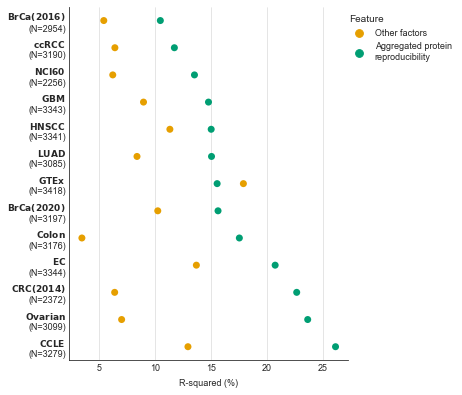

In [16]:
args = gu.additional_plot_parameters(xlab='R-squared (%)', ylab=None, yaxis_grid=False, xaxis_grid=True, 
                                     palette = [gu.get_color(name) for name in ['orange', 'green']],
                                     anchor_legend_at=(1.4, 1))


get_order = lambda df: df[df['Factor']=='Aggregated protein\nreproducibility'].sort_values('R-squared').Data.values
with plt.rc_context({'axes.linewidth': 0.8}):
    figure, ax = plt.subplots(1, 1, figsize=(5,6.5))
    customized_plots.draw_dotplot(ax=ax, x='R-squared', y='Data', data=rsquared_combined_factors, hue='Factor', 
                                  order=get_order(rsquared_combined_factors), args=args, jitter=0)
    ax.spines['left'].set_visible(True)
#     figure.savefig('../figures/S6.svg', bbox_inches='tight', dpi=300)

In [17]:
from scipy import stats
chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [18]:
def lrtest(llmin, llmax, df=3):
    lr = 2 * (llmax - llmin)
    p = chisqprob(lr, df) # llmax has 3 dof more than llmin as protein half-lives as has dummy variables - Long and Short
    return lr, p

In [19]:
for study in all_mRNA_protein_correlation: 
    print(study.name)
    llf_other_factors = ols_fit(x=combined_factors.drop('Protein_Reproducibility',axis=1), y=study).llf    
    llf_aggregated_ranks = ols_fit(x=combined_factors['Protein_Reproducibility'], y=study).llf
    if(study.name == 'GTEx'):
        lr, p = lrtest(llf_aggregated_ranks, llf_other_factors)
        print('Aggregated Protein Reproducibility v/s Other Factors model: LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))
    else:
        lr, p = lrtest(llf_other_factors, llf_aggregated_ranks)
        print('Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = {:.2f},  p value = {:.5g}'.format(lr, p))

CRC (2014)
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 448.37,  p value = 7.3449e-97
BrCa (2016)
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 158.65,  p value = 3.5807e-34
Ovarian
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 605.88,  p value = 5.3462e-131
Colon
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 495.80,  p value = 3.8845e-107
ccRCC
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 182.76,  p value = 2.2308e-39
EC
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 280.56,  p value = 1.6045e-60
LUAD
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 229.12,  p value = 2.1458e-49
BrCa (2020)
Other Factors v/s Aggregated Protein Reproducibility model: LR test statistic = 193.99,  p value = 8.3989e-42
HNSCC
Other Factors v/s Aggregated Protein Reproducibil

<div class="alert alert-block alert-success">
    Based on the above results where p < 0.001 in most cases (except CCLE Abundance v/s combined model), we understand that the combined model is better than the individual model for all the studies considered. However, cases where the LR test statistic is not very large (depending on the predictability of the factors - for e.g., aggreated rank abundance v/s combined model), we can say that  the individual factor model is almost as good as the combined model despite a p < 0.001 </div>